# Monte Carlo Methods for Making Numerical Estimations

## Calculating Pi using the Monte Carlo method

A **Monte Carlo method** is any method that uses randomness to solve problems. The algorithm repeats suitable **random** **sampling** and observes the fraction of samples that obey particular properties in order to make numerical estimations.

Let's do a fun exercise where we approximate the value of π using the MC method. We'll place a large number of random points in a square whose width = 2 (-1<x<1, -1<y<1), and count how many points fall within the circle of unit radius. We all know that the area of the square is $S=2^2=4$ and the area of the circle is $C=\pi*1^2=\pi$. If we divide the area of the circle by the area of the square, we will get $C/S=\pi/4$. $C/S$ can be measured by the fraction of points falling within the circle. As a result, the value of π can be estimated as four times $C/S$.

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

n_point = 1000
points = torch.rand((n_point, 2)) * 2 - 1

n_point_circle = 0
points_circle = []

For each random point, calculate the distance to the origin. A point falls within the circle if the distance is less than 1:

In [ ]:
for point in points:
    r = torch.sqrt(point[0] ** 2 + point[1] ** 2)
    if r <= 1:
        points_circle.append(point)
        n_point_circle += 1

Count the number of points in the circle and keep track of those points:

In [ ]:
points_circle = torch.stack(points_circle)

Plot all random points and use a different color for those in the circle:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

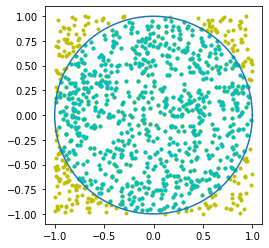

In [ ]:
plt.plot(points[:, 0].numpy(), points[:, 1].numpy(), 'y.')
plt.plot(points_circle[:, 0].numpy(), points_circle[:, 1].numpy(), 'c.')

i = torch.linspace(0, 2 * math.pi)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy())
plt.axes().set_aspect('equal')
plt.show()

The Monte Carlo method is so powerful thanks to the Law of Large Numbers (LLN). Under LLN, the average performance of a large number of repeated events or actions will eventually converge to the expected value. In our case, with a large number of random points, 4 * (n_point_circle / n_point) will eventually converge to the true value of π.

In [ ]:
pi_estimated = 4 * (n_point_circle / n_point)
print('Estimated value of pi is:', pi_estimated)

Estimated value of pi is: 3.1


The value of π approximated using the Monte Carlo method is quite close to its true value (3.14159...).

We can further improve our estimation with more iterations than 1,000. Here, we'll experiment with 10,000 iterations. In each iteration, we randomly generate a point in the square and see whether it is in the circle; we estimate the value of π on the fly based on the fraction of existing points falling within the circle.

We then plot the estimation history along with the true value of π. Put these into the following function:

In [ ]:
def estimate_pi_mc(n_iteration):
    n_point_circle = 0
    pi_iteration = []
    for i in range(1, n_iteration+1):
        point = torch.rand(2) * 2 - 1
        r = torch.sqrt(point[0] ** 2 + point[1] ** 2)
        if r <= 1:
            n_point_circle += 1
        pi_iteration.append(4 * (n_point_circle / i))
    plt.plot(pi_iteration)
    plt.plot([math.pi] * n_iteration, '--')
    plt.xlabel('Iteration')
    plt.ylabel('Estimated pi')
    plt.title('Estimation history')
    plt.show()
    print('Estimated value of pi is:', pi_iteration[-1])

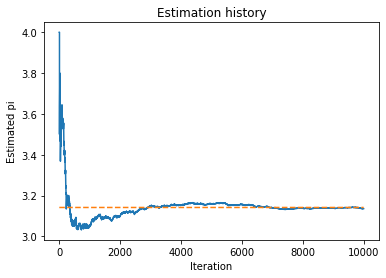

Estimated value of pi is: 3.1356


In [ ]:
estimate_pi_mc(10000)

We can see that with more iterations, the estimation of π is getting closer to the true value. There is always some variation in an event or action. More repetitions can help smooth it out.

## Performing Monte Carlo policy evaluation

MC policy evaluation uses empirical mean return instead of expected return (as in DP) to estimate the value function. There are two ways to perform MC policy evaluation. One is first-visit MC prediction, which averages the returns only for the first occurrence of a state, s, in an episode. Another one is every-visit MC prediction, which averages the returns for every occurrence of a state, s, in an episode. Obviously, first-visit MC prediction has a lot fewer calculations than the every-visit version, hence it is more frequently used.

In [ ]:
import torch
import gym

env = gym.make('FrozenLake-v0')

To evaluate a policy using the Monte Carlo method, we first need to define a function that simulates a FrozenLake episode given a policy and returns the reward and state for each step:

In [ ]:
def run_episode(env, policy):
    state = env.reset()
    rewards = []
    states = [state]
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        states.append(state)
        rewards.append(reward)
        if is_done:
            break
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)
    return states, rewards

In the Monte Carlo setting, we need to keep track of the states and rewards for all steps, since we don't have access to the full environment, including the transition probabilities and reward matrix.

Now, define the function that evaluates the given policy with first-visit MC:

In [ ]:
def mc_prediction_first_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        first_visit = torch.zeros(n_state)
        G = torch.zeros(n_state)
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            return_t = gamma * return_t + reward_t
            G[state_t] = return_t
            first_visit[state_t] = 1
        for state in range(n_state):
            if first_visit[state] > 0:
                V[state] += G[state]
                N[state] += 1
    for state in range(n_state):
        if N[state] > 0:
            V[state] = V[state] / N[state]
    return V

We perform the following tasks in MC prediction:
- We run n_episode episodes
- For each episode, we compute the returns for the first visit of each state
- For each state, we obtain the value by averaging its first returns from all episodes

We specify the discount rate as 1 for easier computation, and simulate 10,000 episodes:

In [ ]:
gamma = 1
n_episode = 10000

optimal_policy = torch.tensor([0., 3., 3., 3., 0., 3., 2., 3., 3., 1., 0., 3., 3., 2., 1., 3.])
value = mc_prediction_first_visit(env, optimal_policy, gamma, n_episode)

print('The value function calculated by first-visit MC prediction:\n', value)

The value function calculated by first-visit MC prediction:
 tensor([0.7415, 0.5075, 0.5018, 0.4413, 0.7415, 0.0000, 0.3870, 0.0000, 0.7415,
        0.7422, 0.6714, 0.0000, 0.0000, 0.8029, 0.8962, 0.0000])


We have just solved the value function of the optimal policy using first-visit MC prediction.

As you can see, in MC-based prediction, it is not necessary to know about the full model of the environment. In fact, in most real-world cases, the transition matrix and reward matrix are not known beforehand, or are extremely difficult to obtain. Imagine how many possible states there are playing chess or Go and the number of possible actions; it is almost impossible to work out the transition matrix and reward matrix. Model-free reinforcement learning is about learning from experience by interacting with the environment.

In our case, we only considered what could be observed, which included the new state and reward in each step, and made predictions using the Monte Carlo method. Note that the more episodes we simulate, the more accurate predictions we can obtain. If you plot the value updated after each episode, you will see how it converges over time, which is similar to what we saw when estimating the value of π.

We decide to also perform every-visit MC prediction for the optimal policy of FrozenLake. We define the function that evaluates the given policy with every-visit MC:

In [ ]:
def mc_prediction_every_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    G = torch.zeros(n_state)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            return_t = gamma * return_t + reward_t
            G[state_t] += return_t
            N[state_t] += 1
    for state in range(n_state):
        if N[state] > 0:
            V[state] = G[state] / N[state]
    return V

value = mc_prediction_every_visit(env, optimal_policy, gamma, n_episode)

print('The value function calculated by every-visit MC prediction:\n', value)

The value function calculated by every-visit MC prediction:
 tensor([0.6262, 0.4353, 0.4035, 0.3684, 0.6272, 0.0000, 0.3645, 0.0000, 0.6484,
        0.6875, 0.6436, 0.0000, 0.0000, 0.7798, 0.8832, 0.0000])


## Playing Blackjack with Monte Carlo prediction

We will play Blackjack (also called 21) and evaluate a policy we think might work well. You will get more familiar with Monte Carlo prediction with the Blackjack example, and get ready to search for the optimal policy using Monte Carlo control.

Blackjack is a popular card game where the goal is to have the sum of cards as close to 21 as possible without exceeding it. The J, K, and Q cards have a points value of 10, and cards from 2 to 10 have values from 2 to 10. The ace card can be either 1 or 11 points; when the latter value is chosen, it is called a usable ace. The player competes against a dealer. At the beginning, both parties are given two random cards, but only one of the dealer's cards is revealed to the player. The player can request additional cards (called hit) or stop receiving any more cards (called stick). After the player sticks, the dealer keeps drawing cards until the sum of cards is greater than or equal to 17. Before the player calls stick, if the sum of their cards exceeds 21 (called going bust), the player loses. Otherwise, if the sum of the dealer's cards exceeds 21, the player wins.

If neither of the two parties goes bust, the one with the highest score will win or it may be a draw. The Blackjack environment in Gym is formulated as follows:

- An episode of the Blackjack finite MDP starts with two cards for each party, and only one of the dealer's cards is observed.
- An episode ends with either party winning or the parties drawing. The final reward of an episode is +1 if the player wins, -1 if they lose, or 0 if a draw occurs.
- In each round, two actions can be taken by the player, hit (1) and stick (0), meaning requesting another card and requesting to not receive any further cards.

We'll first experiment with a simple policy where we keep adding new cards as long as the total number of points is less than 18 (or 19 or 20 if you prefer).

To be continued...

https://learning.oreilly.com/library/view/pytorch-1-x-reinforcement/9781838551964/6ffdc13b-f620-46af-bd6e-ddc0a93baa17.xhtml